Epoch:1/51 Error_train: 1.8075945045721853 Error_test: 1.8302253194319735
Epoch:6/51 Error_train: 0.37474275011394637 Error_test: 0.47619099419479843
Epoch:11/51 Error_train: 0.2045107168658 Error_test: 0.33343965445211704
Epoch:16/51 Error_train: 0.13451140586590857 Error_test: 0.2808540326217516
Epoch:21/51 Error_train: 0.10193501835575178 Error_test: 0.2510687867831041
Epoch:26/51 Error_train: 0.07881492138404465 Error_test: 0.22849523642547542
Epoch:31/51 Error_train: 0.06606629656932288 Error_test: 0.22606948852576889
Epoch:36/51 Error_train: 0.055050173717967034 Error_test: 0.19824675392065963
Epoch:41/51 Error_train: 0.042465241273877914 Error_test: 0.20379195432629824
Epoch:46/51 Error_train: 0.03516677549502789 Error_test: 0.19146139779986446
Epoch:51/51 Error_train: 0.030668644175227334 Error_test: 0.18737589696904258


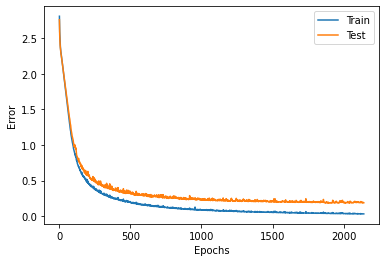

Acc_train: 99.62880475129919% Acc_test: 94.44444444444444%


In [9]:
import numpy as np
# import cupy as np     # GPU를 이용할 경우
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# --각 설정값--
img_size = 8     # 이미지 크기와 폭
n_mid = 16       # 은닉층 뉴런 수
n_out = 10
eta = 0.001      # 학습률
epochs = 51
batch_size = 32
interval = 5     # 경과 시간 표시 간격

digits_data = datasets.load_digits()

# --입력 데이터--
input_data = np.asarray(digits_data.data)
# 평균 0, 표준편차 1
input_data = (input_data - np.average(input_data)) / np.std(input_data)

# --정답 데이터--
correct = np.asarray(digits_data.target)
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1   # 원핫 인코딩
    
# --훈련 데이터와 테스트 데이터로 분할
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

# --전결합층의 부모 클래스
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# --은닉층--
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)      # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)   # ReLU 미분
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# --출력층--
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # 소프트맥스 함수
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

        
# --각 층의 초기화--
layers = [MiddleLayer(img_size*img_size, n_mid),
         MiddleLayer(n_mid, n_mid),
          OutputLayer(n_mid, n_out)]

# --순전파--
def forward_propagation(x):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# --역전파--
def backpropagation(t):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# --파라미터 갱신--
def update_params():
    for layer in layers:
        layer.update(eta)
               
# -- 오차 측정 --
def get_error(x, t):
    y = forward_propagation(x)
    return -np.sum(t*np.log(y+1e-7)) / len(y)    # 교차 엔트로피 오차

# -- 정답률 측정 --
def get_accuracy(x, t):
    y = forward_propagation(x)
    count = np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))
    return count / len(y)

# -- 오차 기록 --
error_record_train = []
error_record_test = []

n_batch = len(x_train) // batch_size               # 1에포크당 배치 개수
for i in range(epochs):
    
    # --학습--
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)    # 인덱스를 임의로 섞기
    for j in range(n_batch):
        
        # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        # 순잔파와 역전파
        forward_propagation(x_mb)
        backpropagation(t_mb)
        
        # 파라미터 갱신
        update_params()
        
        # -- 오차 측정 및 기록 --
        error_train = get_error(x_train, t_train)
        error_record_train.append(error_train)
        error_test = get_error(x_test, t_test)
        error_record_test.append(error_test)
        
    # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:" + str(i+1) + "/" + str(epochs), 
              "Error_train: " + str(error_train),
              "Error_test: " + str(error_test))
            
# -- 오차 추이를 그래프로 표시 --
plt.plot(range(1, len(error_record_train)+1), error_record_train, label="Train")
plt.plot(range(1, len(error_record_test)+1), error_record_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# -- 정답률 측정 --
acc_train = get_accuracy(x_train, t_train)
acc_test = get_accuracy(x_test, t_test)
print("Acc_train: "+str(acc_train*100)+"%",
     "Acc_test: "+str(acc_test*100)+"%")